Analyze 19/5-9 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [9]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    d_dgs_phase['solvent'] = (solvent_dg, solvent_ddg)
    
    return d_dgs_phase
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    

## ALA->VAL

In [29]:
# Load data into dicts and plot 
titles = ["ALA->VAL"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 5
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 5
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/5/5_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/5/5_apo_work_dist.png
-25.67152990295264 0.14523832629567004


<Figure size 432x288 with 0 Axes>

(array([ 7., 20., 21., 17., 21.,  9.,  4.,  0.,  0.,  1.]),
 array([-94.87061871, -73.62586672, -52.38111472, -31.13636273,
         -9.89161074,  11.35314126,  32.59789325,  53.84264524,
         75.08739724,  96.33214923, 117.57690122]),
 <BarContainer object of 10 artists>)

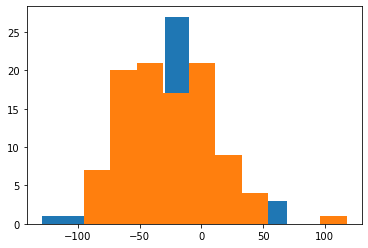

In [30]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [31]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [33]:
output_kcalmol

[-15.36, (-19.52, -11.56)]

In [34]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [35]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

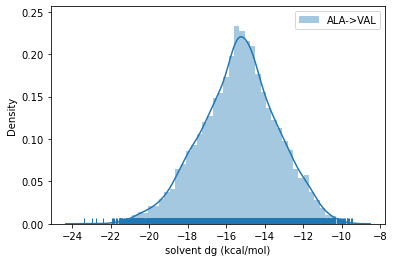

In [36]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->THR

In [37]:
# Load data into dicts and plot 
titles = ["ALA->THR"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 6
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 6
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/6/6_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/6/6_apo_work_dist.png
-43.974242803930004 0.1472638382317298


<Figure size 432x288 with 0 Axes>

(array([ 1.,  0.,  0.,  4.,  7., 22., 32., 23.,  7.,  4.]),
 array([-294.0586995 , -255.88347697, -217.70825443, -179.5330319 ,
        -141.35780937, -103.18258684,  -65.00736431,  -26.83214178,
          11.34308075,   49.51830328,   87.69352581]),
 <BarContainer object of 10 artists>)

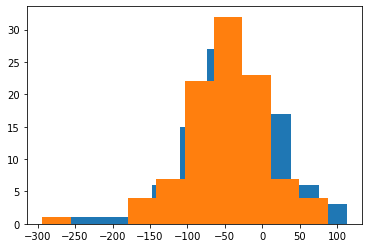

In [38]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [39]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [41]:
output_kcalmol

[-25.62, (-29.95, -20.35)]

In [42]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [43]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

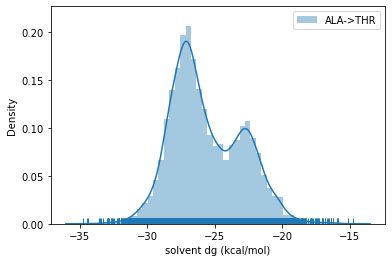

In [44]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->TYR

In [45]:
# Load data into dicts and plot 
titles = ["ALA->LYS"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 7
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 7
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/7/7_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/7/7_apo_work_dist.png
-15.215289038769136 0.13519850767183986


<Figure size 432x288 with 0 Axes>

(array([ 4., 10., 11., 15., 18., 24., 10.,  5.,  2.,  1.]),
 array([-152.35947771, -122.42963879,  -92.49979988,  -62.56996096,
         -32.64012205,   -2.71028313,   27.21955579,   57.1493947 ,
          87.07923362,  117.00907254,  146.93891145]),
 <BarContainer object of 10 artists>)

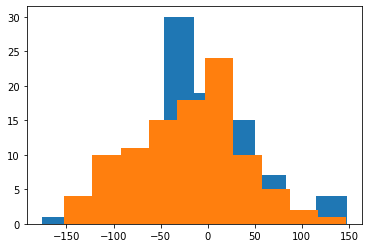

In [46]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [47]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [49]:
output_kcalmol

[-9.18, (-14.24, -4.59)]

In [50]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [51]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

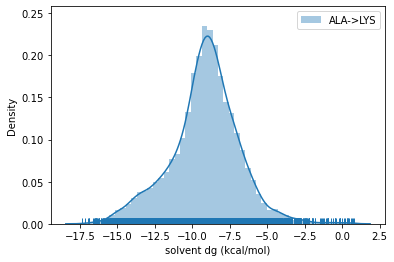

In [52]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->ASP

In [7]:
# Load data into dicts and plot 
titles = ["ALA->ASP"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 8
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 8
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/8/8_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/8/8_apo_work_dist.png
-267.3005252441923 0.13717767299944003


<Figure size 432x288 with 0 Axes>

(array([ 3.,  2., 13., 17., 26., 21., 15.,  2.,  0.,  1.]),
 array([-535.4317901 , -477.23789346, -419.04399681, -360.85010016,
        -302.65620351, -244.46230686, -186.26841021, -128.07451356,
         -69.88061691,  -11.68672026,   46.50717639]),
 <BarContainer object of 10 artists>)

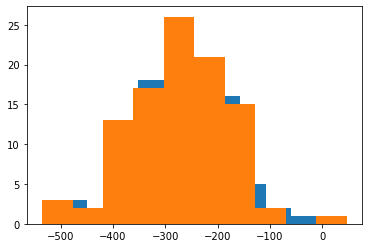

In [6]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [10]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [18]:
output_kcalmol

[-159.15, (-163.89, -151.08)]

In [88]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [19]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

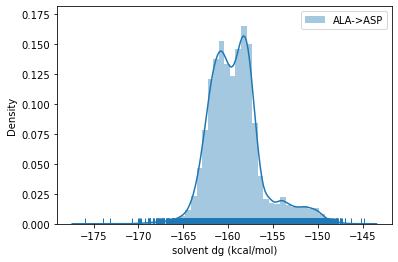

In [20]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->LYS

In [21]:
# Load data into dicts and plot 
titles = ["ALA->LYS"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 9
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 9
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/9/9_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/9/9_apo_work_dist.png
-148.1664285860835 0.15283621634220784


<Figure size 432x288 with 0 Axes>

(array([ 4.,  8., 10., 11., 22., 17., 17.,  5.,  3.,  3.]),
 array([-251.86838132, -231.05955746, -210.2507336 , -189.44190975,
        -168.63308589, -147.82426203, -127.01543817, -106.20661432,
         -85.39779046,  -64.5889666 ,  -43.78014275]),
 <BarContainer object of 10 artists>)

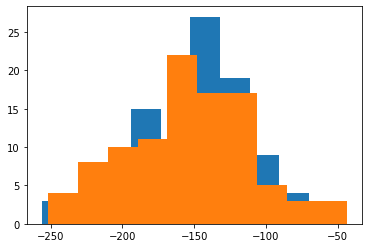

In [22]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [23]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [25]:
output_kcalmol

[-88.52, (-92.91, -85.01)]

In [26]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [27]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

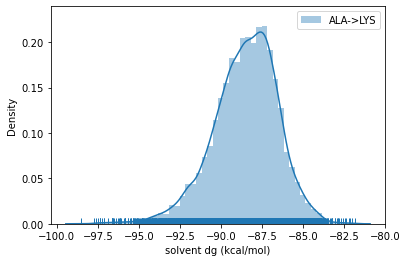

In [28]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()